Avvio dell'analisi DBSCAN...
Etichette vere ('Primary_Position') caricate. Ci sono 11 ruoli unici.
Preprocessing di 52 features numeriche...
Dati imputati e scalati pronti.
Dimensioni (features): 52. Imposto min_samples = 104
Calcolo delle distanze dei vicini (NearestNeighbors)...
Valore 'eps' trovato (euristica 95° percentile): 6.4041
Grafico 'dbscan_eps_plot.png' salvato.
Esecuzione di DBSCAN in corso (eps=6.4041, min_samples=104)...

--- Risultati DBSCAN ---
Numero di cluster trovati (escluso rumore): 1
Numero di punti 'rumore' (etichetta -1): 143 (su 15738 totali)

--- Metriche di Valutazione (vs Etichette Reali) ---
Adjusted Rand Index (ARI): 0.0001
Normalized Mutual Information (NMI): 0.0008

--- Confronto con KMeans (k=11, tutte le features) ---
KMeans ARI (precedente): 0.2491
KMeans NMI (precedente): 0.3697
Risultato: KMeans (forzato a 11 cluster) era più allineato ai 11 ruoli.

--- Matrice di Contingenza DBSCAN (Righe: Posizioni Vere, Colonne: Cluster Trovati) ---
La colonna '

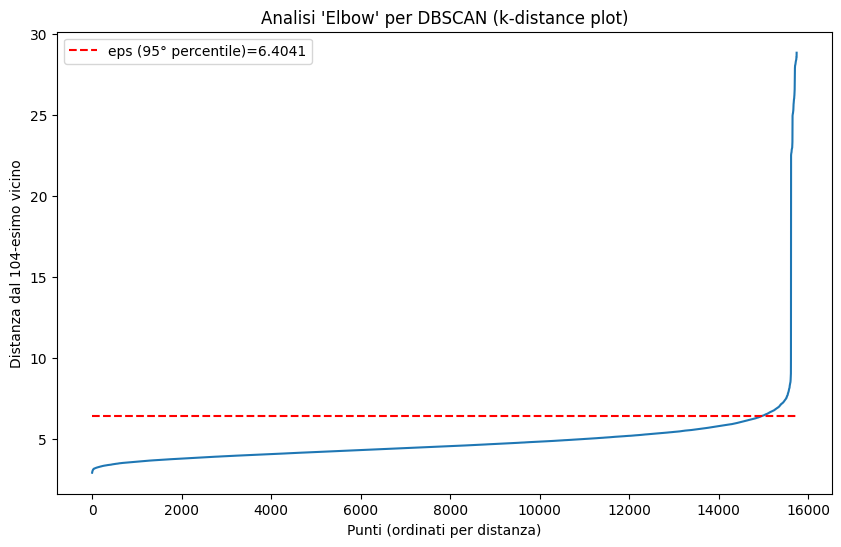

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings

# Sopprime i warning
warnings.filterwarnings('ignore')

print("Avvio dell'analisi DBSCAN...")

# Carica il dataset
file_path = 'data/puliti/movimento_fe.csv'
try:
    df = pd.read_csv(file_path)

    # --- 1. Preparazione delle "Etichette Vere" (per la valutazione) ---
    df['Primary_Position'] = df['Position'].apply(lambda x: x.split(',')[0].strip() if pd.notnull(x) else 'Unknown')
    df = df[df['Primary_Position'] != 'Unknown']
    true_labels = df['Primary_Position']
    k_true = true_labels.nunique()
    print(f"Etichette vere ('Primary_Position') caricate. Ci sono {k_true} ruoli unici.")

    # --- 2. Preparazione delle "Features" (X) ---
    X = df.select_dtypes(include='number').copy()
    features_used = X.columns.tolist()
    print(f"Preprocessing di {len(features_used)} features numeriche...")
    
    # --- 3. Preprocessing (Imputazione e Scaling) ---
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    print("Dati imputati e scalati pronti.")

    # --- 4. Analisi per trovare 'eps' e 'min_samples' ---
    D = X_scaled.shape[1]
    min_samples = 2 * D
    print(f"Dimensioni (features): {D}. Imposto min_samples = {min_samples}")

    print("Calcolo delle distanze dei vicini (NearestNeighbors)...")
    nn = NearestNeighbors(n_neighbors=min_samples, n_jobs=-1)
    nn.fit(X_scaled)
    distances, indices = nn.kneighbors(X_scaled)
    
    kth_distances = distances[:, min_samples - 1]
    kth_distances_sorted = np.sort(kth_distances)

    # --- 5. Trovare 'eps' (Metodo alternativo) ---
    # Dato che l'installazione di 'kneed' è fallita,
    # usiamo un'euristica comune: il 95° percentile.
    chosen_eps = np.percentile(kth_distances_sorted, 95)
    print(f"Valore 'eps' trovato (euristica 95° percentile): {chosen_eps:.4f}")

    # --- 6. Salvare il grafico del gomito ---
    plt.figure(figsize=(10, 6))
    plt.plot(kth_distances_sorted)
    plt.hlines(chosen_eps, xmin=0, xmax=len(kth_distances_sorted), linestyles='--', colors='r', label=f'eps (95° percentile)={chosen_eps:.4f}')
    plt.legend()
    plt.xlabel("Punti (ordinati per distanza)")
    plt.ylabel(f"Distanza dal {min_samples}-esimo vicino")
    plt.title("Analisi 'Elbow' per DBSCAN (k-distance plot)")
    plt.savefig('dbscan_eps_plot.png')
    print("Grafico 'dbscan_eps_plot.png' salvato.")

    # --- 7. Eseguire DBSCAN ---
    print(f"Esecuzione di DBSCAN in corso (eps={chosen_eps:.4f}, min_samples={min_samples})...")
    dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples, n_jobs=-1)
    cluster_labels = dbscan.fit_predict(X_scaled)

    # --- 8. Analisi Risultati DBSCAN ---
    n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise_ = list(cluster_labels).count(-1)
    
    print(f"\n--- Risultati DBSCAN ---")
    print(f"Numero di cluster trovati (escluso rumore): {n_clusters_}")
    print(f"Numero di punti 'rumore' (etichetta -1): {n_noise_} (su {len(df)} totali)")

    # --- 9. Valutazione e Confronto ---
    ari_score = metrics.adjusted_rand_score(true_labels, cluster_labels)
    nmi_score = metrics.normalized_mutual_info_score(true_labels, cluster_labels)
    
    print("\n--- Metriche di Valutazione (vs Etichette Reali) ---")
    print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")

    print("\n--- Confronto con KMeans (k=11, tutte le features) ---")
    print("KMeans ARI (precedente): 0.2491")
    print("KMeans NMI (precedente): 0.3697")
    
    if ari_score > 0.2491:
        print("Risultato: DBSCAN è più allineato ai ruoli.")
    else:
        print("Risultato: KMeans (forzato a 11 cluster) era più allineato ai 11 ruoli.")

    # --- 10. Matrice di Contingenza ---
    df['DBSCAN_Cluster'] = cluster_labels
    contingency_matrix_dbscan = pd.crosstab(df['Primary_Position'], df['DBSCAN_Cluster'])
    print("\n--- Matrice di Contingenza DBSCAN (Righe: Posizioni Vere, Colonne: Cluster Trovati) ---")
    print("La colonna '-1' rappresenta il 'rumore' (outlier)")
    print(contingency_matrix_dbscan)
    contingency_matrix_dbscan.to_csv('contingency_matrix_dbscan.csv')

except FileNotFoundError:
    print(f"Errore: File '{file_path}' non trovato.")
except Exception as e:
    print(f"Si è verificato un errore: {e}")

Avvio dell'analisi PCA + DBSCAN...
Etichette vere ('Primary_Position') caricate. Ci sono 11 ruoli unici.
Preprocessing di 52 features numeriche...
Dati imputati e scalati pronti.
Applicazione della PCA in corso...
PCA completata. 52 features ridotte a 28 componenti.
Varianza spiegata: 95.53%
Nuove dimensioni (PCA components): 28. Imposto min_samples = 15
Calcolo delle distanze dei vicini (sui dati PCA)...
Valore 'eps' impostato manualmente: 5.0258
Grafico 'dbscan_pca_eps_plot.png' salvato.
Esecuzione di DBSCAN in corso (eps=5.0258, min_samples=15)...

--- Risultati DBSCAN + PCA ---
Numero di cluster trovati (escluso rumore): 1
Numero di punti 'rumore' (etichetta -1): 225 (su 15738 totali)

--- Metriche di Valutazione (DBSCAN + PCA) ---
Adjusted Rand Index (ARI): 0.0004
Normalized Mutual Information (NMI): 0.0012

--- Confronto con KMeans (k=11, tutte le 52 features) ---
KMeans (52 feats) ARI: 0.2491
KMeans (52 feats) NMI: 0.3697
Risultato: KMeans (forzato a 11 cluster) era più allineat

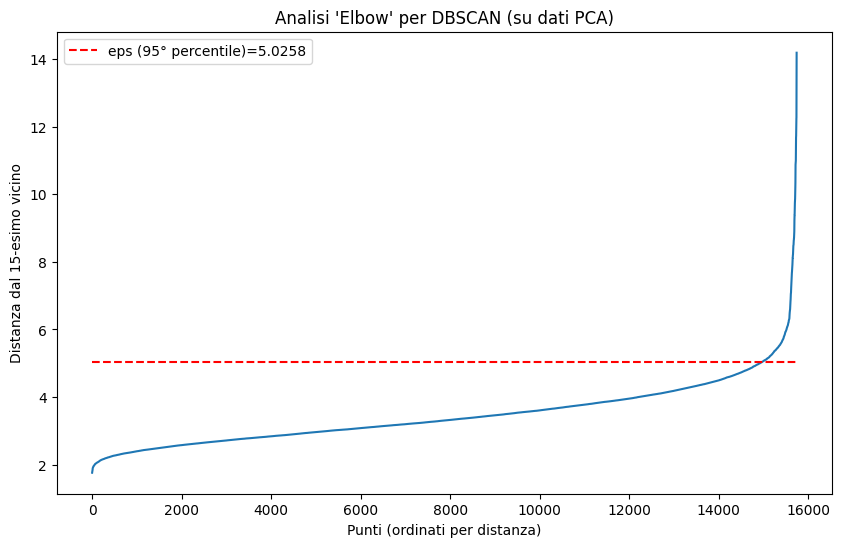

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA  # <-- IMPORT AGGIUNTO
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings

# Sopprime i warning
warnings.filterwarnings('ignore')

print("Avvio dell'analisi PCA + DBSCAN...")

# Carica il dataset
file_path = 'data/puliti/movimento_fe.csv'
try:
    df = pd.read_csv(file_path)

    # --- 1. Preparazione delle "Etichette Vere" (per la valutazione) ---
    df['Primary_Position'] = df['Position'].apply(lambda x: x.split(',')[0].strip() if pd.notnull(x) else 'Unknown')
    df = df[df['Primary_Position'] != 'Unknown']
    true_labels = df['Primary_Position']
    k_true = true_labels.nunique()
    print(f"Etichette vere ('Primary_Position') caricate. Ci sono {k_true} ruoli unici.")

    # --- 2. Preparazione delle "Features" (X) ---
    X = df.select_dtypes(include='number').copy()
    features_used = X.columns.tolist()
    print(f"Preprocessing di {len(features_used)} features numeriche...")
    
    # --- 3. Preprocessing (Imputazione e Scaling) ---
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    print("Dati imputati e scalati pronti.")

    # --- 4. MODIFICA: Riduzione Dimensionale (PCA) ---
    print("Applicazione della PCA in corso...")
    pca = PCA(n_components=0.95, random_state=42)
    # Applichiamo PCA ai dati scalati
    X_pca = pca.fit_transform(X_scaled)
    
    n_components_pca = pca.n_components_
    explained_variance_pca = np.sum(pca.explained_variance_ratio_)
    print(f"PCA completata. {X_scaled.shape[1]} features ridotte a {n_components_pca} componenti.")
    print(f"Varianza spiegata: {explained_variance_pca * 100:.2f}%")
    
    # ORA X_scaled VIENE SOSTITUITO DA X_pca PER TUTTO IL RESTO
    # =======================================================

    # --- 5. Analisi per 'eps' (SUI DATI PCA) ---
    # La dimensionalità D è ora il numero di componenti PCA
    D = X_pca.shape[1] 
    #min_samples = 2 * D
    min_samples = 15
    print(f"Nuove dimensioni (PCA components): {D}. Imposto min_samples = {min_samples}")

    print("Calcolo delle distanze dei vicini (sui dati PCA)...")
    nn = NearestNeighbors(n_neighbors=min_samples, n_jobs=-1)
    # Fit sui dati X_pca
    nn.fit(X_pca) 
    distances, indices = nn.kneighbors(X_pca)
    
    kth_distances = distances[:, min_samples - 1]
    kth_distances_sorted = np.sort(kth_distances)

    # --- 6. Trovare 'eps' (SUI DATI PCA) ---
    chosen_eps = np.percentile(kth_distances_sorted, 95)
    chosen_eps = 3.3  # <-- INSERISCI MANUALMENTE IL VALORE DEL GOMITO
    print(f"Valore 'eps' impostato manualmente: {chosen_eps:.4f}")
    

    # --- 7. Salvare il grafico del gomito (PCA) ---
    plt.figure(figsize=(10, 6))
    plt.plot(kth_distances_sorted)
    plt.hlines(chosen_eps, xmin=0, xmax=len(kth_distances_sorted), linestyles='--', colors='r', label=f'eps (95° percentile)={chosen_eps:.4f}')
    plt.legend()
    plt.xlabel("Punti (ordinati per distanza)")
    plt.ylabel(f"Distanza dal {min_samples}-esimo vicino")
    plt.title("Analisi 'Elbow' per DBSCAN (su dati PCA)")
    plt.savefig('dbscan_pca_eps_plot.png')
    print("Grafico 'dbscan_pca_eps_plot.png' salvato.")

    # --- 8. Eseguire DBSCAN (SUI DATI PCA) ---
    print(f"Esecuzione di DBSCAN in corso (eps={chosen_eps:.4f}, min_samples={min_samples})...")
    dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples, n_jobs=-1)
    # Predict sui dati X_pca
    cluster_labels = dbscan.fit_predict(X_pca)

    # --- 9. Analisi Risultati DBSCAN + PCA ---
    n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise_ = list(cluster_labels).count(-1)
    
    print(f"\n--- Risultati DBSCAN + PCA ---")
    print(f"Numero di cluster trovati (escluso rumore): {n_clusters_}")
    print(f"Numero di punti 'rumore' (etichetta -1): {n_noise_} (su {len(df)} totali)")

    # --- 10. Valutazione e Confronto ---
    ari_score = metrics.adjusted_rand_score(true_labels, cluster_labels)
    nmi_score = metrics.normalized_mutual_info_score(true_labels, cluster_labels)
    
    print("\n--- Metriche di Valutazione (DBSCAN + PCA) ---")
    print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")

    print("\n--- Confronto con KMeans (k=11, tutte le 52 features) ---")
    print("KMeans (52 feats) ARI: 0.2491")
    print("KMeans (52 feats) NMI: 0.3697")
    
    if ari_score > 0.2491:
        print("Risultato: DBSCAN + PCA è più allineato ai ruoli.")
    else:
        print("Risultato: KMeans (forzato a 11 cluster) era più allineato ai 11 ruoli.")

    # --- 11. Matrice di Contingenza ---
    df['DBSCAN_PCA_Cluster'] = cluster_labels
    contingency_matrix_dbscan_pca = pd.crosstab(df['Primary_Position'], df['DBSCAN_PCA_Cluster'])
    print("\n--- Matrice di Contingenza DBSCAN + PCA (Righe: Posizioni Vere, Colonne: Cluster Trovati) ---")
    print("La colonna '-1' rappresenta il 'rumore' (outlier)")
    print(contingency_matrix_dbscan_pca)
    contingency_matrix_dbscan_pca.to_csv('contingency_matrix_dbscan_pca.csv')

except FileNotFoundError:
    print(f"Errore: File '{file_path}' non trovato.")
except Exception as e:
    print(f"Si è verificato un errore: {e}")